# Returns, risk and diversification

When choosing between different assets for your portfolio, we seek to balance two measures: risk and return. Returns are the price changes in a certain asset, and constitute the profit (or loss) on the investment. Although simple returns, i.e. percent changes, are very common, in finance it is also standard to work with logarithmic returns, because of continuous compounding.

Logarithmic returns are given by the formula $r_{log} = \ln \Big( \frac{P_f}{P_i} \Big) = \ln P_f - \ln P_i$

It's easy to import returns from Yahoo Finance into Python with the yfinance package, and calculate log returns with numpy

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

aapl = yf.Ticker("AAPL").history(period="max") # import daily prices fo AAPL

aapl['Close'].head() # .head() gives us the first 5 observations of a pandas series/dataframe

Date
1980-12-12    0.099319
1980-12-15    0.094137
1980-12-16    0.087228
1980-12-17    0.089387
1980-12-18    0.091978
Name: Close, dtype: float64

In [2]:
aapl_log = np.diff(np.log(aapl['Close'].values)) # obtaing log returns: first apply log and then the first difference
aapl_log

array([-0.05358035, -0.07623125,  0.02444962, ...,  0.00051782,
        0.00222382, -0.00543889])

We can also use the methods of the pd.Series class from pandas

In [3]:
aapl_log = aapl['Close'].apply(np.log).diff()
aapl_log

Date
1980-12-12         NaN
1980-12-15   -0.053580
1980-12-16   -0.076231
1980-12-17    0.024450
1980-12-18    0.028580
                ...   
2023-12-22   -0.005563
2023-12-26   -0.002845
2023-12-27    0.000518
2023-12-28    0.002224
2023-12-29   -0.005439
Name: Close, Length: 10853, dtype: float64

matplotlib allows us to make plots and see what prices and returns look like

<Axes: xlabel='Date'>

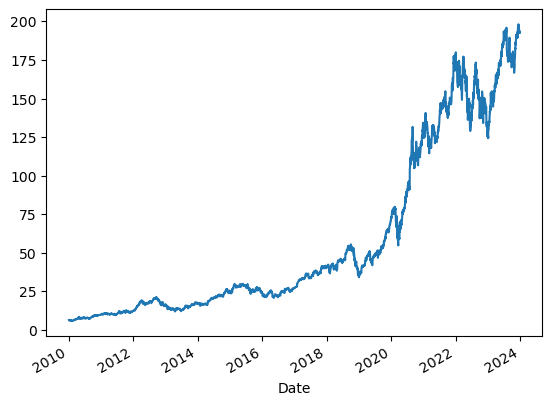

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

aapl['Close']['2010-01-01':].plot(title="Price") # using the .plot() method from pandas, which is based off matplotlib

<Axes: xlabel='Date'>

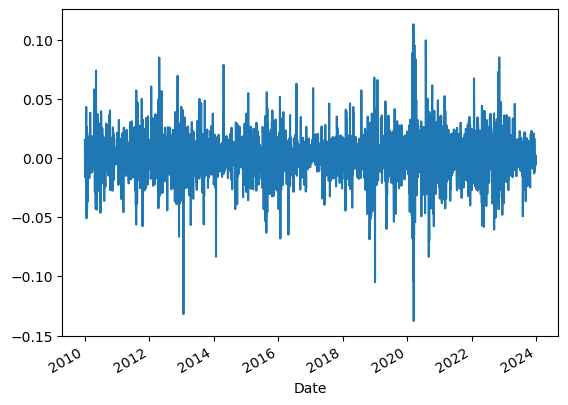

In [5]:
aapl_log['2010-01-01':].plot(title="Returns")

Returns can also be plotted as histograms, so we can see their distribution

<Axes: ylabel='Frequency'>

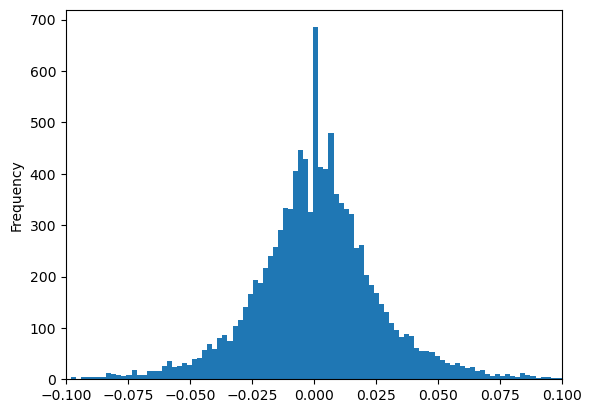

In [6]:
aapl_log.plot(kind="hist",bins=500,xlim=(-0.1,0.1), title="Distribution of returns") # plot histogram by passing kind="hist" to the .plot() method

Now, moving on to risk. There are many different types of financial risk, but the standard deviation of returns, also known as volatility, is the common measure of risk for a given asset.

We can sample from normal distributions with different standard deviations and notice their difference (pay attention to the horizontal axis):

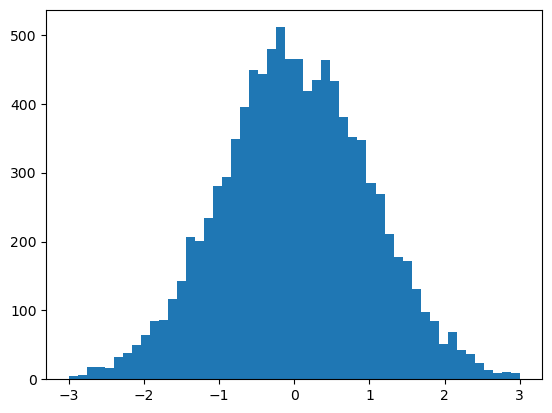

In [7]:
normal_1 = 1 * np.random.randn(10000) # standard deviation: 1
normal_2 = 1.5 * np.random.randn(10000) # standard deviation: 1.5

plt.hist(normal_1, bins = 50, range=(-3,3)) # plot histogram with pandas plt.hist() command
plt.show()

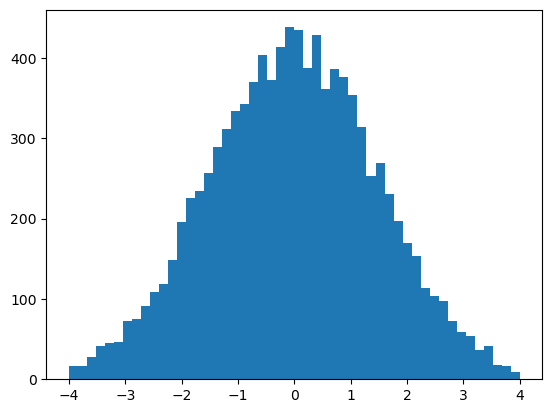

In [8]:
plt.hist(normal_2, bins = 50, range=(-4,4))
plt.show()

When looking at more than one asset, we also need to account for correlations and covariances. These two measures are similar, and quantify how much the prices of two assets move with one another.

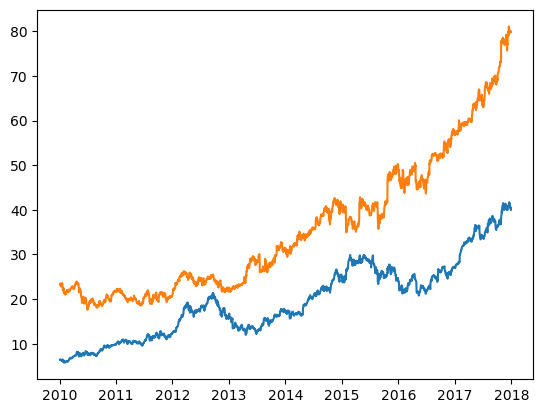

[[ 75.29277942 125.55106662]
 [125.55106662 244.0328956 ]]
[[1.         0.92623152]
 [0.92623152 1.        ]]


In [9]:
aapl = yf.Ticker("AAPL").history(period="max")["Close"]['2010-01-01':'2018-01-01']
msft = yf.Ticker("MSFT").history(period="max")["Close"]['2010-01-01':'2018-01-01']
mcd = yf.Ticker("MCD").history(period="max")["Close"]['2010-01-01':'2018-01-01']

plt.plot(aapl)
plt.plot(msft)
plt.show()
print(np.cov(aapl,msft)) # print covariances
print(np.corrcoef(aapl,msft)) # print correlation coefficients

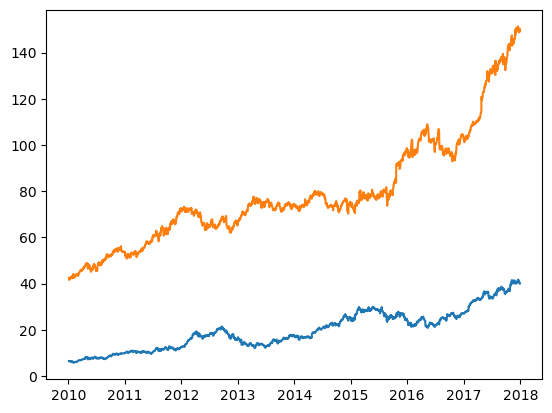

[[ 75.29277942 186.78671169]
 [186.78671169 579.79475673]]
[[1.         0.89398899]
 [0.89398899 1.        ]]


In [10]:
plt.plot(aapl)
plt.plot(mcd)
plt.show()
print(np.cov(aapl,mcd))
print(np.corrcoef(aapl,mcd))

Agents invest by seeking the highest possible return for a given risk tolerance, or the lowest possible risk for a given amount of return. Covariances are of great importance because they will dictate the risk for your portfolio as a whole, and therefore the amounts to be invested on each asset.

## Mean-variance optimization

The famous asset allocation framework pioneered by Markowitz, known as mean-variance optimization, seeks to minimize covariances between assets in order to obtain the asset combination with the best risk-return relation.

For a vector of weights $\{w_1,\ldots,w_n\}$, $\sum_{i=1}^n w_i = 1$, the expected return of the portfolio shall be

$\operatorname{E}[r_p] = \sum_{i=1}^n w_i \operatorname{E}[r_i]$,

and the portfolio variance is

$\sigma^2_p = \sum_{i=1}^n \sum_{j=1}^n w_i w_j \sigma_{ij}$.

The mean-variance optimization problem is 

$\min w^T \Sigma w$,

subject to

$r^T w = \mu$,

$\mathbf{1}^T w = 1$.

We can implement mean-variance optimization in Python manually

In [11]:
returns_df = pd.concat([aapl,msft,mcd],axis=1).apply(np.log).diff()
returns_df.columns = ["AAPL","MSFT","MCD"]

In [12]:
import scipy.optimize as opt

mean_vec = returns_df.mean().values # mean vector
cov_matrix = returns_df.cov().values # covariance matrix

def mv_obj(w_vec): # defining the objective function
    return w_vec @ cov_matrix @ w_vec

delta = 0.0007 # our targeted level of return

opt.minimize(mv_obj, x0 = np.array([0.3,0.05,0.65]), bounds=((0, 1), (0, 1), (0, 1)), constraints = ({'type': 'eq', 'fun': lambda w_vec: (w_vec @ np.ones(len(w_vec)))- 1}, {'type': 'eq', 'fun': lambda w_vec: (w_vec @ mean_vec) - delta}))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 8.326507160617804e-05
       x: [ 2.716e-01  6.545e-02  6.630e-01]
     nit: 2
     jac: [ 2.124e-04  1.458e-04  1.498e-04]
    nfev: 8
    njev: 2

Or we can use a library such as PyPortfolioOpt

In [13]:
from pypfopt.efficient_frontier import EfficientFrontier

delta = 0.0007

ef = EfficientFrontier(mean_vec, cov_matrix)  # setup
ef.efficient_return(delta)

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


OrderedDict([(0, 0.2716120025847957),
             (1, 0.0661191344615702),
             (2, 0.6622688629536342)])

## Additional references for this section

Campbell, J. Y. (2017). Financial Decisions and Markets: A Course in Asset Pricing. Chapter 1 describes how economic agents take decisions in face of risk and Chapter 2 details portfolio choice with multiple risky assets.

Elton, E. J., Gruber, M. J., Goetzmann, W. N., Brown, S. J. (2014). Modern Portfolio Theory and Investment Analysis. Chapters 4 to 11 are a more thorough introduction to topics such as the risk-return tradeoff, efficient frontier, asset correlations and portfolio selection.